In [ ]:
# i have used different deep learning models with different embedding of words 

In [6]:
import numpy as np
import pandas as pd

In [7]:
import sys, os, re, csv, codecs
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Conv1D, concatenate, Flatten, Concatenate
from tensorflow.keras.layers import  BatchNormalization, Dropout, Activation, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

In [8]:
from sklearn.metrics import hamming_loss
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [9]:
multi_train = pd.read_csv('train.csv')

multi_validation = pd.read_csv('dev.csv')

multi_test = pd.read_csv('test.csv')

In [10]:
# change the column names
multi_train.rename(columns={"Ogling/Facial Expressions/Staring": "Staring", "Touching /Groping": "Touching"}, inplace=True)
multi_validation.rename(columns={"Ogling/Facial Expressions/Staring": "Staring", "Touching /Groping": "Touching"},inplace=True)
multi_test.rename(columns={"Ogling/Facial Expressions/Staring": "Staring", "Touching /Groping": "Touching"},inplace=True)

In [11]:
multi_train.head()

,Description,Commenting,Staring,Touching
0,"Was walking along crowded street, holding mums...",0,0,1
1,This incident took place in the evening.I was ...,0,1,0
2,I WAS WAITING FOR THE BUS. A MAN CAME ON A BIK...,1,0,0
3,Incident happened inside the train,0,0,0
4,I witnessed an incident when a chain was bruta...,0,0,0


In [12]:
# Drop Duplicates

# keep the first occurance of duplicates for all three datasets and drop the rest

multi_train.drop_duplicates(keep = 'first', inplace=True)
multi_validation.drop_duplicates(keep = 'first', inplace=True)
multi_test.drop_duplicates(keep = 'first', inplace=True)

In [13]:
train = pd.concat([multi_train, multi_validation], axis=0 ) # concat train and validation set 
train.head()

,Description,Commenting,Staring,Touching
0,"Was walking along crowded street, holding mums...",0,0,1
1,This incident took place in the evening.I was ...,0,1,0
2,I WAS WAITING FOR THE BUS. A MAN CAME ON A BIK...,1,0,0
3,Incident happened inside the train,0,0,0
4,I witnessed an incident when a chain was bruta...,0,0,0


In [14]:
test = multi_test  # test set

In [15]:
train.shape, test.shape

((7735, 4), (1640, 4))

In [16]:
y_train = train[['Commenting', 'Staring', 'Touching']].values
y_test = test[['Commenting', 'Staring', 'Touching']].values

## Tokenization and Padding

In [17]:
# Text Data 
description_train_text =list(train['Description'].values)
description_test_text = list(test['Description'].values)

# tokenize the Text data
tokenizer = tf.keras.preprocessing.text.Tokenizer()
# fit on train data
tokenizer.fit_on_texts(description_train_text)     
# transform train and test data
train_description_sequences = tokenizer.texts_to_sequences(description_train_text)
test_description_sequences = tokenizer.texts_to_sequences(description_test_text)

# vocabulary size 
vocab_size = len(tokenizer.word_index) + 1

# pad the sequnce

train_description_padded = pad_sequences(
        train_description_sequences, maxlen=300, dtype='int32', padding='post',  
        truncating='post')                                                  

test_description_padded = pad_sequences(
        test_description_sequences, maxlen=300, dtype='int32', padding='post', 
        truncating='post')                                  

In [19]:
# Exact match ratio
def exact_match_ratio(y_true, y_pred):
    MR = np.all(y_pred == y_true, axis=1).mean()
    return MR

In [20]:
# conver probabilities to labels

def prob_to_class(arr):   # converts probailities to class labes based on 0.5 threshold
    r,c = arr.shape
    predict =np.zeros((r, c))
    for i in range(r):
        for j in range(c):
            if arr[i,j]>0.5:
                predict[i,j] = 1
    return predict

# FastText Embeddings

In [21]:
from gensim.models.fasttext import FastText
%matplotlib inline 

In [22]:
import nltk

In [23]:
max_input=300

In [24]:
embedding_size = 300  #  size of the embedding vector. 
window_size = 20    # size of the number of words occurring before and after the word based on which the word representations.
min_word = 5  # minimum frequency of a word in the corpus for which the word representations will be generated
down_sampling = 1e-2   # most frequently occurring word will be down-sampled by a number specified by the down_sampling 

In [25]:
word_punctuation_tokenizer = nltk.WordPunctTokenizer()
word_tokenized_corpus = [word_punctuation_tokenizer.tokenize(sent) for sent in description_train_text]

In [26]:
%%time
ft_model = FastText(word_tokenized_corpus,
                      vector_size=embedding_size,
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      sg=1,
                      epochs=100)

CPU times: total: 14min 23s
Wall time: 5min 6s


In [27]:
embedding_matrix_fast_text = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
  try:
    embedding_vector = ft_model.wv[word] # getting the vector for each word
  except:
    embedding_vector = np.zeros(300)
  
  if embedding_vector is not None:
    embedding_matrix_fast_text[i] = embedding_vector

In [28]:
embedding_matrix_fast_text

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.03347188, -0.05775065,  0.03388294, ..., -0.02005111,
         0.08853608, -0.01838219],
       [-0.10528477, -0.03000548,  0.06240652, ...,  0.09761441,
         0.09758147,  0.01911058],
       ...,
       [-0.16969073, -0.00279967,  0.12458664, ...,  0.18027425,
        -0.02612464, -0.05381318],
       [-0.85372454,  0.29582784,  0.28048775, ..., -0.16623107,
         0.49024644,  0.03248863],
       [-0.19320852,  0.1312938 ,  0.13664408, ..., -0.13441198,
         0.08269598,  0.03528953]])

## CNN with FastText Embedding

In [30]:
from tensorflow.keras.initializers import Constant

In [33]:
input = Input(shape=(max_input,), name='Descripton text')  # input 

embedding = Embedding(vocab_size, embedding_size, embeddings_initializer=Constant(embedding_matrix_fast_text), trainable=False)(input)  # embedding layer

x = SpatialDropout1D(0.2)(embedding)

z = GlobalMaxPool1D()(x)

conv = Conv1D(64, 4, activation="relu")(x)

x = GlobalMaxPool1D()(conv)

x = Concatenate()([x,z])

x = Dropout(0.3)(x)

output = Dense(3, activation="sigmoid")(x)

model_2_fast_text = Model(inputs=input, outputs=output)

In [34]:
model_2_fast_text.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.BinaryAccuracy()])
history = model_2_fast_text.fit(train_description_padded, y_train, batch_size=32, epochs=20, validation_data=(test_description_padded, y_test))  

Epoch 1/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/step - binary_accuracy: 0.7207 - loss: 0.5742 - val_binary_accuracy: 0.8260 - val_loss: 0.4107
Epoch 2/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - binary_accuracy: 0.8384 - loss: 0.3990 - val_binary_accuracy: 0.8392 - val_loss: 0.3920
Epoch 3/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 24s 99ms/step - binary_accuracy: 0.8592 - loss: 0.3519 - val_binary_accuracy: 0.8409 - val_loss: 0.3893
Epoch 4/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 27s 113ms/step - binary_accuracy: 0.8702 - loss: 0.3208 - val_binary_accuracy: 0.8382 - val_loss: 0.3908
Epoch 5/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 26s 107ms/step - binary_accuracy: 0.8774 - loss: 0.3003 - val_binary_accuracy: 0.8404 - val_loss: 0.3969
Epoch 6/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 27s 112ms/step - binary_accuracy: 0.8940 - loss: 0.2670 - val_binary_accuracy: 0.8415 - val_loss: 0.4029
Epoch 7/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 26s 107ms/step - binary_accuracy: 0.9101 - loss: 0.2353 - val_binary_accuracy: 0.8370 - val_l

In [35]:
score = model_2_fast_text.evaluate(test_description_padded, y_test, batch_size=64, verbose=1)
print("Loss:", score[0])
print("Accuracy:", score[1])

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - binary_accuracy: 0.8148 - loss: 0.7118
Loss: 0.6392565965652466
Accuracy: 0.8290650844573975


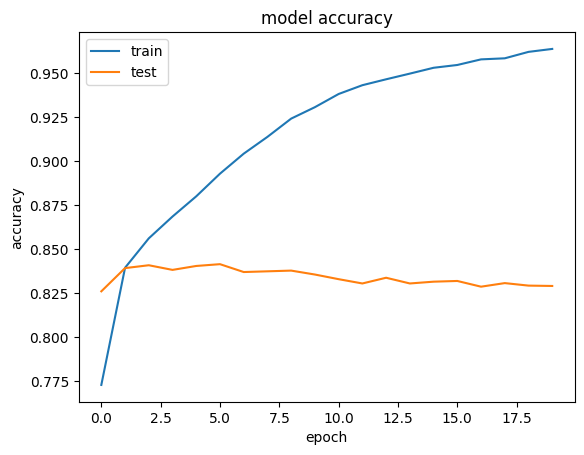

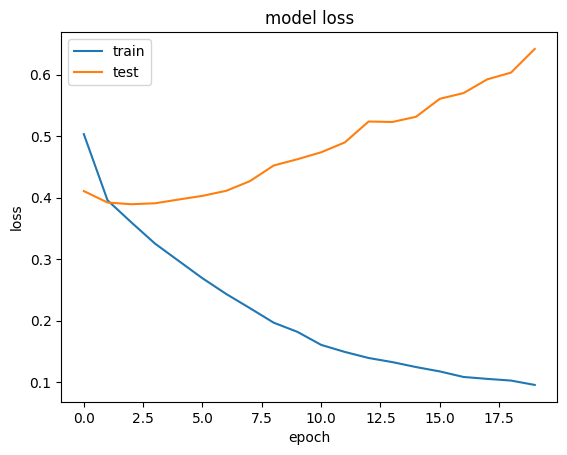

In [36]:
import matplotlib.pyplot as plt

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [37]:
y_pred = model_2_fast_text.predict(test_description_padded, batch_size=64)
y_class = prob_to_class(y_pred)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


In [38]:
print("Hamming Loss: ", hamming_loss(y_test, y_class))
print("Exact Match Ratio: ", exact_match_ratio(y_test, y_class))
print("Recall: ", recall_score(y_test, y_class, average='micro'))
print("Precision: ", precision_score(y_test, y_class, average='micro'))
print("Fl score: ", f1_score(y_true=y_test, y_pred=y_class, average='micro'))

Hamming Loss:  0.1709349593495935
Exact Match Ratio:  0.6109756097560975
Recall:  0.5868544600938967
Precision:  0.7954545454545454
Fl score:  0.6754148977228869


In [90]:
predict=pd.concat([test['Description'],pd.DataFrame(y_class)],axis=1)
predict=predict.loc[0:1620,:]
predict.rename(columns={0:'Commenting',1:'Ogling/Facial Expressions/Staring',2:'Touching /Groping'},inplace=True)
predict.to_csv('prediction1.csv', index=False)

## Bidirectional LSTM With FastText Embedding

In [40]:
# ref : # https://www.kaggle.com/CVxTz/keras-bidirectional-lstm-baseline-lb-0-069

input = Input(shape=(max_input,), name='Descripton text')  # input 

embedding = Embedding(vocab_size, embedding_size, embeddings_initializer=Constant(embedding_matrix_fast_text), trainable=False)(input)  # embedding layer
x = SpatialDropout1D(0.3)(embedding)

x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(x)

x = GlobalMaxPool1D()(x)

x = Dropout(0.2)(x)

x = Dense(100, activation="relu")(x)

x = BatchNormalization()(x)

x = Dropout(0.2)(x)   

output = Dense(3, activation="sigmoid")(x)

model_fast_text = Model(inputs=input, outputs=output)

In [41]:
model_fast_text.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.BinaryAccuracy()])
history = model_fast_text.fit(train_description_padded, y_train, batch_size=32, epochs=10, validation_data=(test_description_padded, y_test))  

Epoch 1/10


242/242 ━━━━━━━━━━━━━━━━━━━━ 122s 488ms/step - binary_accuracy: 0.6507 - loss: 0.6543 - val_binary_accuracy: 0.8045 - val_loss: 0.4579
Epoch 2/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 104s 430ms/step - binary_accuracy: 0.8210 - loss: 0.4305 - val_binary_accuracy: 0.8323 - val_loss: 0.4092
Epoch 3/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 110s 453ms/step - binary_accuracy: 0.8441 - loss: 0.3869 - val_binary_accuracy: 0.8268 - val_loss: 0.4085
Epoch 4/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 104s 429ms/step - binary_accuracy: 0.8401 - loss: 0.3889 - val_binary_accuracy: 0.8380 - val_loss: 0.3922
Epoch 5/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 94s 386ms/step - binary_accuracy: 0.8531 - loss: 0.3608 - val_binary_accuracy: 0.8415 - val_loss: 0.3893
Epoch 6/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 97s 401ms/step - binary_accuracy: 0.8663 - loss: 0.3388 - val_binary_accuracy: 0.8394 - val_loss: 0.3908
Epoch 7/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 113s 467ms/step - binary_accuracy: 0.8705 - loss: 0.3250 - val_binary_accuracy: 0.8354 - val_loss

In [42]:
score = model_fast_text.evaluate(test_description_padded, y_test, verbose=1)
print("Loss:", score[0])
print("Accuracy:", score[1])

52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - binary_accuracy: 0.8255 - loss: 0.4651
Loss: 0.43212711811065674
Accuracy: 0.8353659510612488


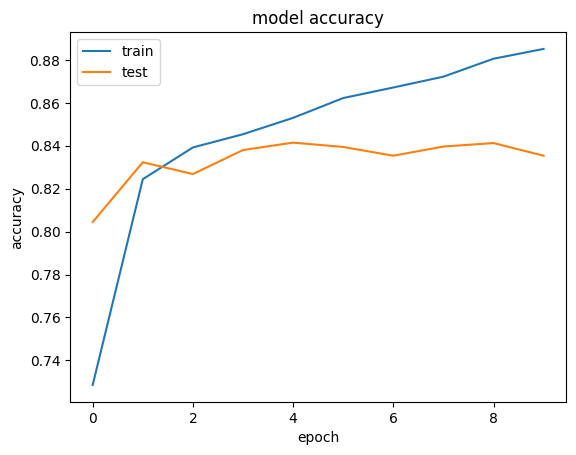

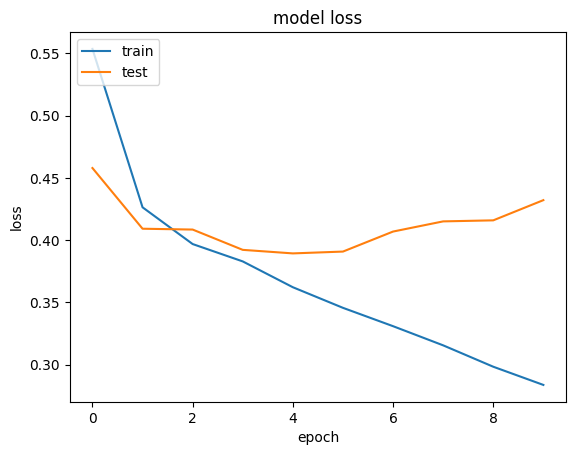

In [43]:
import matplotlib.pyplot as plt

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [44]:
y_pred = model_fast_text.predict(test_description_padded, batch_size=64)
y_class = prob_to_class(y_pred)

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step


In [45]:
print("Hamming Loss: ", hamming_loss(y_test, y_class))
print("Exact Match Ratio: ", exact_match_ratio(y_test, y_class))
print("Recall: ", recall_score(y_test, y_class, average='micro'))
print("Precision: ", precision_score(y_test, y_class, average='micro'))
print("Fl score: ", f1_score(y_true=y_test, y_pred=y_class, average='micro'))

Hamming Loss:  0.16463414634146342
Exact Match Ratio:  0.625
Recall:  0.6331321260898726
Precision:  0.7821043910521955
Fl score:  0.6997776130467013


In [91]:
predict=pd.concat([test['Description'],pd.DataFrame(y_class)],axis=1)
predict=predict.loc[0:1620,:]
predict.rename(columns={0:'Commenting',1:'Ogling/Facial Expressions/Staring',2:'Touching /Groping'},inplace=True)
predict.to_csv('prediction2.csv', index=False)